In [1]:
import numpy as np

In [2]:
from dataclasses import dataclass
from typing import Tuple, Mapping, Dict, Sequence, Iterable, Set, List

In [16]:
import matplotlib.pyplot as plt

In [17]:
s = "SPACE"
b = "BLOCK"
g = "GOAL"
maze_grid = {(0, 0): 'SPACE', (0, 1): 'BLOCK', (0, 2): 'SPACE', (0, 3): 'SPACE', (0, 4): 'SPACE', 
             (0, 5): 'SPACE', (0, 6): 'SPACE', (0, 7): 'SPACE', (1, 0): 'SPACE', (1, 1): 'BLOCK',
             (1, 2): 'BLOCK', (1, 3): 'SPACE', (1, 4): 'BLOCK', (1, 5): 'BLOCK', (1, 6): 'BLOCK', 
             (1, 7): 'BLOCK', (2, 0): 'SPACE', (2, 1): 'BLOCK', (2, 2): 'SPACE', (2, 3): 'SPACE', 
             (2, 4): 'SPACE', (2, 5): 'SPACE', (2, 6): 'BLOCK', (2, 7): 'SPACE', (3, 0): 'SPACE', 
             (3, 1): 'SPACE', (3, 2): 'SPACE', (3, 3): 'BLOCK', (3, 4): 'BLOCK', (3, 5): 'SPACE', 
             (3, 6): 'BLOCK', (3, 7): 'SPACE', (4, 0): 'SPACE', (4, 1): 'BLOCK', (4, 2): 'SPACE', 
             (4, 3): 'BLOCK', (4, 4): 'SPACE', (4, 5): 'SPACE', (4, 6): 'SPACE', (4, 7): 'SPACE', 
             (5, 0): 'BLOCK', (5, 1): 'BLOCK', (5, 2): 'SPACE', (5, 3): 'BLOCK', (5, 4): 'SPACE', 
             (5, 5): 'BLOCK', (5, 6): 'SPACE', (5, 7): 'BLOCK', (6, 0): 'SPACE', (6, 1): 'BLOCK', 
             (6, 2): 'BLOCK', (6, 3): 'BLOCK', (6, 4): 'SPACE', (6, 5): 'BLOCK', (6, 6): 'SPACE', 
             (6, 7): 'SPACE', (7, 0): 'SPACE', (7, 1): 'SPACE', (7, 2): 'SPACE', (7, 3): 'SPACE', 
             (7, 4): 'SPACE', (7, 5): 'BLOCK', (7, 6): 'BLOCK', (7, 7): 'GOAL'}

In [18]:
def track(f):
    def wrapped(mdp, vf, s):
        res = f(mdp, vf, s)
        updated = vf.copy()
        mdp.iterates.append(updated)
    return wrapped


@dataclass(frozen=True)
class GridState:
    '''Your code here'''
    x: int
    y: int
    
    def neighbors(self):
        return [GridState(self.x - 1, self.y), GridState(self.x + 1, self.y),
                GridState(self.x, self.y - 1), GridState(self.x, self.y + 1)]

    def __lt__(self, other):
        return (self.x, self.y) < (other.x, other.y)
    
    

class GridMazeMDP:
    
    def __init__(self, maze_dict):
        self.iterates = [] # do not change
        self.tolerance = 1e-8
        '''Your code here, initialize the data you need to solve the MDP
        '''
        self.states: Set[GridState] = set([GridState(x[0], x[1]) for x, y in maze_dict.items()
                                           if y == 'SPACE' or y == 'GOAL'])
        self.goal: GridState = [GridState(x[0], x[1]) for x, y in maze_dict.items() if y == 'GOAL'][0]
        self.gamma: float = 1
    
    def plot_convergence(self):
        '''do not change'''
        sorted_vfs = np.array([[y[1] for y in sorted(x.items())] for x in self.iterates])
        true_vf = sorted_vfs[-1, :]
        convergences = np.linalg.norm(sorted_vfs - true_vf, axis=1)
        plt.plot(convergences)
    
    @track
    def update_value_function_for_state(self, value_function: Mapping[GridState, float], s: GridState):
        '''
        Your code here: perform an in place update to value function for state 
        Runetime: O(1)
        '''
        if s != self.goal:
            neighbor_value_functions = []
            for neighbor in s.neighbors():
                if neighbor == self.goal:
                    neighbor_value_functions.append(1 + self.gamma*value_function[neighbor])
                elif neighbor in self.states:
                    neighbor_value_functions.append(self.gamma*value_function[neighbor])
            value_function[s] = max(neighbor_value_functions)
        else:
            value_function[s] = 0
            
    
    def in_place_value_iteration(self) -> Mapping[GridState, float]:
        '''Your code here (Maybe, maybe leave as an example)
        run in place value iteration until the max change of the VF over all states
        is less than self.tolerance
        hint: this implementation should call update_value_function_for_state in it's inner loop
        '''
        value_function = {s: 0 for s in self.states}
        max_change = 1
        while max_change > self.tolerance:
            max_change = 0
            for state in self.states:
                old_val = value_function[state]
                self.update_value_function_for_state(value_function, state)
                max_change = max(max_change, abs(old_val - value_function[state]) > self.tolerance)
        return value_function
    
    
    def influence_tree_VI(self) -> Mapping[GridState, float]:
        '''Your code here
        run value tree iteration as descibed in the algorithm until the max change of 
        the VF over all states is less than self.tolerance
        hint: make sure you are not adding states to the update set more than you need to
        '''
        value_function = {s: 0 for s in self.states}
        influence_tree = self.get_influence_tree()
        to_update = [s for s in self.states]
        in_list = {s: True for s in self.states}
        while len(to_update) > 0:
            next_state = to_update.pop(0)
            in_list[next_state] = False
            old_val = value_function[next_state]
            self.update_value_function_for_state(value_function, next_state)
            if abs(old_val - value_function[next_state]) > self.tolerance:
                for s in influence_tree[next_state]:
                    if not in_list[s]:
                         to_update.append(s)
        return value_function
            
            
    def get_influence_tree(self):
        '''just a method I wrote, does not need to be implemented to solve the problem'''
        influence_tree = {}
        count = 0
        for state in self.states:
            influence_tree[state] = []
            for neighbor in state.neighbors():
                if neighbor != self.goal and neighbor in self.states:
                    influence_tree[state].append(neighbor)
        return influence_tree

    

In [19]:
gm1 = GridMazeMDP(maze_grid)
gm2 = GridMazeMDP(maze_grid)

In [20]:
vf1 = gm1.in_place_value_iteration()

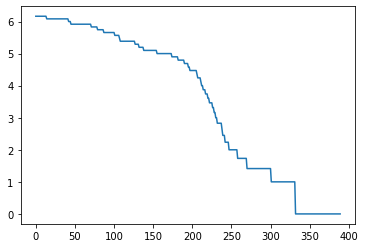

In [21]:
gm1.plot_convergence()

In [22]:
vf2 = gm2.influence_tree_VI()

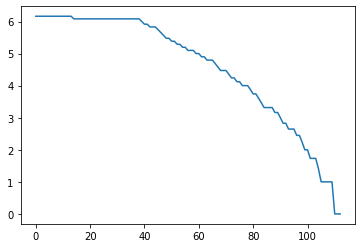

In [23]:
gm2.plot_convergence()